1. We have a peptidome $p_i \in P$
2. We want to create a graph $G$ that generates* $P$. To do this:
    - Generate peptidome from $G$. Calculate KL-divergence $\delta$ between generated peptidome and $\hat{p_i}$
    - for pair $(u_i, u_j)$ where $(u_i \in u_j) \in P$. Add $lr \times \delta \times u_i$ to $w_{i,j}$ where $w_{i,j}$ is the weight of the edge between the nodes and $lr$ some learning rate.
    - Penalize reliance on a single node by $\epsilon \times \sum_i{w_{i,j}}$ where $\epsilon$ is some penalty factor.
    - Make differences of 1 amino acid more likely (due to exoproteases).
    


*To generate a peptidome from $G$. Let $N_T$ be the number of peptides in $P$. Start from the largest peptide. The peptide is cleaved with probability $w_{i,j}$. Iterate until number of peptides $\geq N_T$.

In [1]:
def normalize_dict(d):
    s = sum(d.values())
    return {k: v / s for k, v in d.items()}

In [2]:
import numpy as np

# Generate synthetic sample
P = {
    "ABCD": 20,
    "ABC": 20,
    "BCD": 5,
    "BC": 5,
    "CD": 10,
    "C": 10,
    "AB": 20,
    "B": 10,
    "A": 5,
    
}
keys = list(P.keys())
values = list(P.values())
probs = [v / sum(values) for v in values]


In [3]:
import networkx as nx

N_T = sum(values)
G = nx.DiGraph()
G.add_nodes_from([(k, {"layer": len(k)}) for k in keys])
for key1 in keys:
    for key2 in keys:
        if (key2.startswith(key1) or key2.endswith(key1)) and key1 != key2:  # key 1 = ABC, key 2 = ABCD
            G.add_edge(key2, key1, weight=1)
G.edges(data=True)

OutEdgeDataView([('ABCD', 'ABC', {'weight': 1}), ('ABCD', 'BCD', {'weight': 1}), ('ABCD', 'CD', {'weight': 1}), ('ABCD', 'AB', {'weight': 1}), ('ABCD', 'A', {'weight': 1}), ('ABC', 'BC', {'weight': 1}), ('ABC', 'C', {'weight': 1}), ('ABC', 'AB', {'weight': 1}), ('ABC', 'A', {'weight': 1}), ('BCD', 'BC', {'weight': 1}), ('BCD', 'CD', {'weight': 1}), ('BCD', 'B', {'weight': 1}), ('BC', 'C', {'weight': 1}), ('BC', 'B', {'weight': 1}), ('CD', 'C', {'weight': 1}), ('AB', 'B', {'weight': 1}), ('AB', 'A', {'weight': 1})])

In [4]:
def generate_guess(G, keys, N_T):
    longest_key = sorted(keys, key=len)[-1]
    p_generated = {key: 0 for key in keys}
    N_T_hat = 0
    while N_T_hat < N_T:
        p_generated[longest_key] += 1
        for sequence, copy_number in p_generated.items():
            if copy_number == 0:
                continue
            out_edges = G.out_edges(sequence, data=True)
            weights = np.array([weight["weight"] for _, _, weight in out_edges])
            edges_to = [edge_to for _, edge_to, _ in out_edges]
            for w, e in zip(weights, edges_to):
                p_generated[e] += w * copy_number
        N_T_hat = sum(p_generated.values())
    return p_generated


p_generated = generate_guess(G, keys, N_T)
p_generated

{'ABCD': 3,
 'ABC': 6,
 'BCD': 6,
 'BC': 20,
 'CD': 16,
 'C': 65,
 'AB': 16,
 'B': 65,
 'A': 41}

In [5]:
def KL(a, b):
    a = np.asarray(list(a))
    b = np.asarray(list(b))
    a = 1e-8 + a / np.sum(a)
    b = 1e-8 + b / np.sum(b)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))


kl = KL(P.values(), p_generated.values())

lr = 0.001  # learning rate


# time to update the graph G
def update_weights(G, kl, p_hat, p_generated, lr, verbose=False):
    p_hat = normalize_dict(p_hat)
    p_generated = normalize_dict(p_generated)
    for key in keys:
        out_edges = G.out_edges(key, data=True)
        total_out = sum([data["weight"] for _,_,data in out_edges])
        for _, target, weight in out_edges:
            origin_copy_number = p_hat[key]
            target_copy_number = p_hat[target]
            generated_target_copy_number = p_generated[target]
            diff = target_copy_number - generated_target_copy_number

            # incentivize exoprotease. This is shit. How make good?


            new_weight = max(
                0, weight["weight"] + (diff * lr * kl)
            )  # weight cannot be less than 0
            if verbose:
                print(diff, weight, new_weight)
            # TODO: Need to add penalization here as well
            nx.set_edge_attributes(G, {(key, target): {"weight": new_weight}})
    return G


G = update_weights(G, kl, P, p_generated, lr)


In [6]:
# The loop

lr = 1

generated = {}
kls = []
# given P
for i in range(1000):
    # p_hat = sample(keys, probs, n_sample)
    p_generated = generate_guess(G, keys, N_T)
    generated[i] = p_generated
    kl = KL(P.values(), p_generated.values())
    G = update_weights(G, kl, P, p_generated, lr)
    kls.append(kl)
    weight_sum = sum([weight["weight"] for _, _, weight in G.edges(data=True)])
print(min(kls))

0.00336141857325875


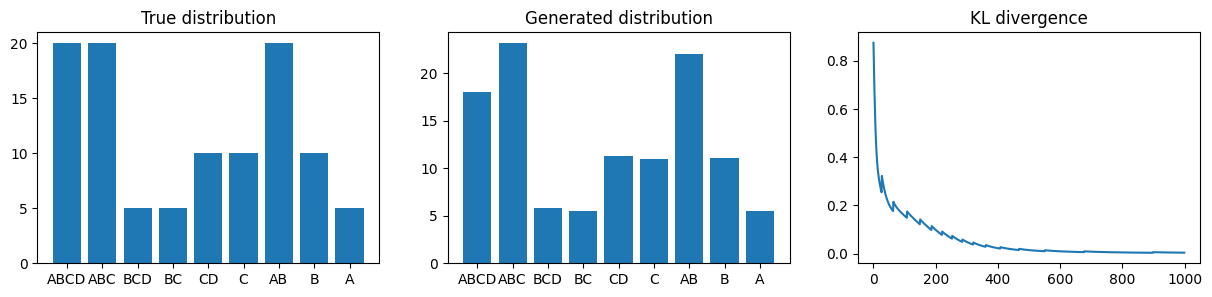

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
p_generated = generated[list(generated.keys())[-1]]
axs[0].bar(P.keys(), P.values())
axs[1].bar(p_generated.keys(), p_generated.values())
axs[2].plot(kls)
axs[0].set_title("True distribution")
axs[1].set_title("Generated distribution")
axs[2].set_title("KL divergence")
plt.show()

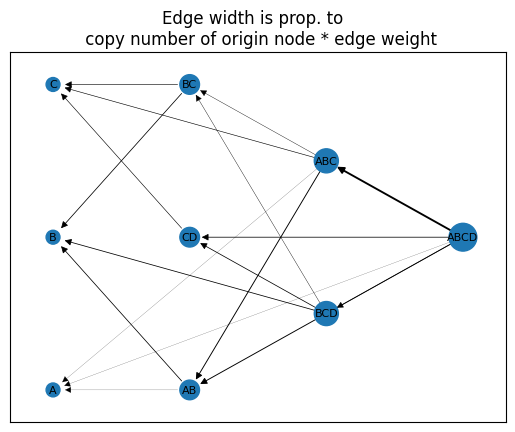

In [8]:
def draw_weighted_network(G, p_generated):
    pos = nx.multipartite_layout(G, subset_key="layer")
    node_size = [len(s) * 100 for s in G.nodes()]
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_size)
    nx.draw_networkx_labels(G, pos=pos, font_size=8)
    edge_width = [
        weight["weight"] * 10 for f, _, weight in G.edges(data=True)
    ]
    nx.draw_networkx_edges(G, pos=pos, width=edge_width)
    plt.title("Edge width is prop. to  \n copy number of origin node * edge weight")


draw_weighted_network(G, p_generated)

In [9]:
from disassembly.disassembly import get_disassembly_indexes
disassembly_indexes = get_disassembly_indexes(G, p_generated)
print(disassembly_indexes)
from disassembly.disassembly import get_disassembly
get_disassembly(P, disassembly_indexes)

{'ABCD': 0, 'ABC': 1.0, 'BCD': 1.0, 'BC': 2.0, 'CD': 1.5, 'C': 2.5, 'AB': 1.5, 'B': 2.5, 'A': 1.8333333333333333}


4.579692338287184